##### ДЗ_26
##### Татур А.А.
##### v.01
##### 12.02.2023
##### Цель : Распознавание первых 10-ти рукописных букв английского алфавита, которые представлены в виде одиночных PNG файлов при помощи нейронных сетей.

### Необходимые импорты

In [3]:
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, CategoryEncoding, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.math import confusion_matrix

import tensorflow as tf
import gc

In [4]:
#### Функция для выведения рандомных 9 цифр и их истинных и предсказанных меток
def graph_rand_nine(model, X_test, y_test, conv=False):
    LABELS = 'ABCDEFGHIJ'
    plt.figure(figsize=(5,7))
    for x in range (9):
        to_predict = np.random.randint(0,len(X_test))
        plt.subplot (3,3,x+1)
        plt.imshow(np.array(X_test[to_predict]).reshape(28,28), cmap='gray')
        if conv:
            predicted = LABELS[np.argmax(model.predict(np.array(X_test[to_predict]).reshape(1,28,28,1)))]
        else:
            predicted = LABELS[np.argmax(model.predict(np.array(X_test[to_predict]).reshape(1,784)))]
        true = LABELS[np.argmax(y_test[to_predict])]
        title = 'Predicted - ' + predicted + '\n' + 'True - ' + true
        plt.title (title);

In [5]:
#### Функция для построения графика обучения на тренировочном и обучающем наборе:
def test_val_graph (history):
    plt.plot(history.history['categorical_accuracy'], label='Точность на обучающем наборе')
    plt.plot(
        history.history['val_categorical_accuracy'], label='Точность на проверочном наборе')
    plt.xlabel('Цикл обучения')
    plt.ylabel('Точность')
    plt.legend()
    plt.show()
    pass;

#### Загрузка файлов и формирование обучающей выборки

In [6]:
X = [] #Массив с изображениями
y = [] #Массив со значениями

In [7]:
ones_array = np.ones(shape=(28,28))      ####### Эти два массива нужны для проверки и удаления из набора неинформативных 
zeroes_array = np.zeros(shape=(28,28))   ####### изображений, которые представляют собой только массивы из нулей или единиц

for folder_name in os.listdir ('data'):
    for file_name in os.listdir('data\\'+folder_name):
        image=plt.imread('data\\' + folder_name + '\\' + file_name)
        if (np.array(image)==ones_array).all()==False and (np.array(image)!=zeroes_array).all()==False:
            y.append(folder_name)
            X.append (image)

In [8]:
encoding = CategoryEncoding(num_tokens=10, output_mode="one_hot")
y_enc = encoding (LabelEncoder().fit_transform(y)).numpy()

In [9]:
X_reshaped = np.array(X).reshape(len(X),784,)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_enc, test_size=0.3, random_state=42)

In [11]:
X_val = X_train[:1000]; X_train = X_train[1000:] ##### Формируем валидационные и
y_val = y_train[:1000]; y_train = y_train[1000:] ##### тренировочные сеты

#### Построим стандартную полносвязную нейронную сеть

In [13]:
checkpoint_cb = ModelCheckpoint("StandardModel.h5", 
                                monitor = 'val_categorical_accuracy',
                                save_best_only=True)
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

In [67]:
model = Sequential()
model.add(Dense(1000, activation='relu'))
model.add(Dropout(rate=0.7))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(rate=0.7))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(rate=0.7))
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.7))
model.add(Dense(10, activation='linear'))

model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=[CategoricalAccuracy()])

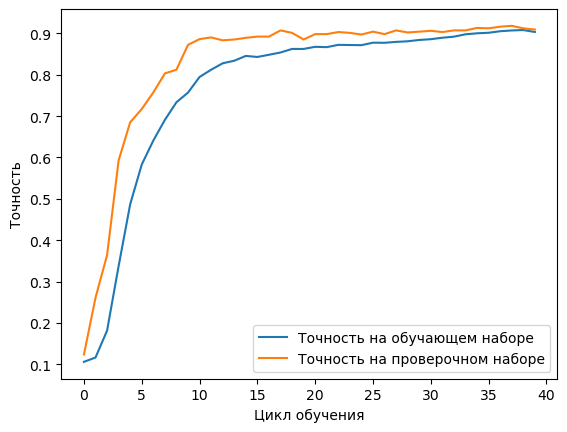

In [68]:
history = model.fit(X_train, y_train, 
                    batch_size=256, epochs=40, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb, lr_scheduler],
                   verbose=0)
test_val_graph (history)

In [69]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            (None, 1000)              785000    
                                                                 
 dropout_58 (Dropout)        (None, 1000)              0         
                                                                 
 dense_78 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_59 (Dropout)        (None, 1000)              0         
                                                                 
 dense_79 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_60 (Dropout)        (None, 1000)              0         
                                                                 
 dense_80 (Dense)            (None, 100)             

In [70]:
del model
gc.collect()

6884

In [71]:
model = load_model("StandardModel.h5")

In [72]:
model.evaluate(X_test, y_test)

173/173 [==============================] - 1s 3ms/step - loss: 0.4166 - categorical_accuracy: 0.9325


[0.41655629873275757, 0.9324618577957153]

1/1 [==============================] - 0s 24ms/step


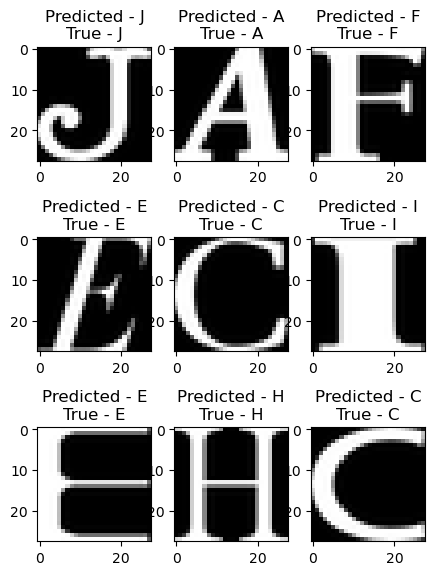

In [73]:
### Строим графики предсказанных и отображаем их метки.
graph_rand_nine(model, X_test, y_test, conv=False)

In [74]:
del model
gc.collect()

24929

#### Построим сверточную нейронную сеть

In [75]:
np.array(X).shape

(18359, 28, 28)

In [76]:
X_exp = np.expand_dims(X, axis=3)

In [77]:
np.array(X_exp).shape

(18359, 28, 28, 1)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X_exp, y_enc, test_size=0.3, random_state=42)

In [79]:
X_val = X_train[:1000]; X_train = X_train[1000:]
y_val = y_train[:1000]; y_train = y_train[1000:]

In [82]:
checkpoint_cb_conv = ModelCheckpoint("ConvModel.h5", 
                                     monitor = 'val_categorical_accuracy',
                                     save_best_only=True)

lr_scheduler = ReduceLROnPlateau(factor=0.2, patience=5)

In [110]:
model_conv = Sequential()

model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu', input_shape=(28,28,1)))
model_conv.add (Conv2D(64, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(128, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))
model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (Conv2D(256, (3,3), padding='same', activation='relu'))
model_conv.add (MaxPooling2D(pool_size=(2,2), strides=2))

model_conv.add(Flatten())

model_conv.add(Dense(4096, activation='relu'))
model_conv.add(Dropout(rate=0.7))
model_conv.add(Dense(4096, activation='relu'))
model_conv.add(Dropout(rate=0.7))
model_conv.add(Dense(100, activation='relu'))
model_conv.add(Dropout(rate=0.8))

model_conv.add(Dense(10, activation='linear'))

model_conv.compile(optimizer=Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=[CategoricalAccuracy()])

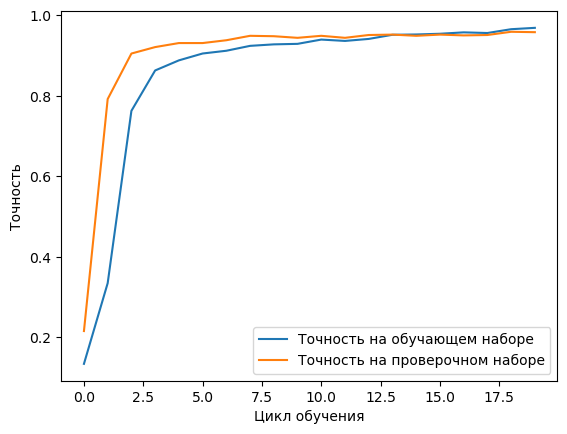

In [111]:
history_conv = model_conv.fit(X_train, y_train, 
                    batch_size=256, epochs=20, 
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_cb_conv,lr_scheduler],
                    verbose=0)

test_val_graph (history_conv)

In [112]:
model_conv.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_70 (Conv2D)          (None, 28, 28, 64)        640       
                                                                 
 conv2d_71 (Conv2D)          (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 14, 14, 128)       73856     
                                                                 
 conv2d_73 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 7, 7, 128)        0         
 g2D)                                                

In [113]:
del model_conv
gc.collect()

7165

In [118]:
model_conv = load_model("ConvModel.h5")

In [119]:
model_conv.evaluate(X_test, y_test);

173/173 [==============================] - 1s 7ms/step - loss: 0.2916 - categorical_accuracy: 0.9544


1/1 [==============================] - 0s 30ms/step


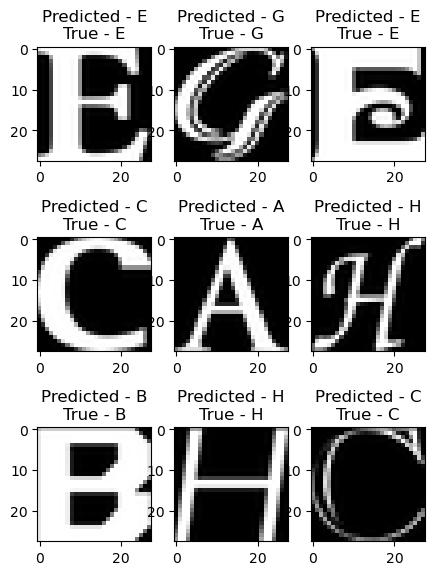

In [120]:
graph_rand_nine(model_conv, X_test, y_test, conv=True)

In [121]:
del model_conv
gc.collect()

31630

##### Вывод:
Применение сверточных нейронных сетей позволяет значительно повысить качество распознавания изображений. Так, на использованном датасете мы видим, что применение обычных полносвязных сетей дает результат 0.9324 на тестовой выборке, тогда как сверточных - 0.9544